In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModel

import torch
from datasets import load_dataset

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from umap import UMAP

import emoji

In [2]:
df = pd.read_csv("backhand_index_pointing_right.csv",
engine="python",
encoding="utf-8",
on_bad_lines="skip", # or 'warn' to see which lines fail
quoting=1 # 1 = csv.QUOTE_NONE to ignore quotes
)

print(df.head())

                                                Text
0  🧡@KeplerHomes AirdropBox event for #Arbitrum e...
1  Remember, success in online business is a mara...
2  @occupied_9 @Rhiannon_clare_ @FightHaven Thank...
3  Hungry for active mutuals👬👭? Follow fastest Re...
4  📢 It's confirmed. Whitelist for Shardeum Airdr...


In [ ]:
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name)

emojis = [
    # 😀 Smiles / Happiness / Fun
    "😀", "😃", "😄", "😁", "😆", "😅", "😂", "🤣", "😎", "😊",
    "😇", "😉", "😋", "😜", "🥳", "🤩", "😺", "😸", "😹", "😻",
    
    # 😢 Sad / Cry / Disappointed
    "😢", "😭", "😞", "😔", "😟", "😕", "🥺", "😩", "😫", "😖",
    
    # ❤️ Love / Affection
    "❤️", "💛", "💚", "💙", "💜", "🖤", "💔", "❣️", "💕", "💖",
    "💗", "💘", "💞", "💓", "💝",
    
    # 🤔 Thinking / Confused / Curious
    "🤔", "🤨", "😐", "😑", "😶", "😬", "😏", "🙄",
    
    # 😡 Anger / Frustration
    "😡", "😠", "🤯", "😤", "😒", "😾",
    
    # 🔥 Excitement / Hype / Energy
    "🔥", "💥", "✨", "⚡", "🌟", "🎉", "🎊",
    
    # 🥰 Affection / Cute / Positive Vibes
    "🥰", "😍", "😘", "😗", "😙", "😚", "😻", "🤗", "🤤",
    
    # 🐾 Animals / Nature
    "🐶", "🐱", "🐭", "🐹", "🐰", "🦊", "🐻", "🐼", "🐨", "🐯",
    "🦁", "🐮", "🐷", "🐸", "🐵", "🐔", "🐧", "🐦", "🐤", "🐣",
    
    # ⚽ Activities / Sports / Travel
    "⚽", "🏀", "🏈", "⚾", "🎾", "🏐", "🏉", "🏓", "🏸", "🏒",
    "✈️", "🚗", "🚕", "🚙", "🛵", "🚲", "🏖️", "🏔️", "🏕️",
    
    # 🍔 Food / Drinks
    "🍏", "🍎", "🍐", "🍊", "🍋", "🍌", "🍉", "🍇", "🍓", "🍒",
    "🥑", "🥦", "🥕", "🌽", "🥔", "🍠", "🍞", "🥐", "🥖", "🧀",
    "🍔", "🍟", "🍕", "🌭", "🥪", "🌮", "🌯", "🥗", "🍿", "🍩",
    
    # 🎶 Music / Entertainment
    "🎵", "🎶", "🎼", "🎤", "🎧", "🎷", "🎸", "🎹", "🥁", "🎺",
    
    # 🏠 Objects / Symbols / Misc
    "⌚", "📱", "💻", "🖥️", "🖨️", "🎮", "📷", "📹", "🔑", "💡",
    "💎", "📦", "🛒", "✏️", "📖", "📚", "📌", "🖊️", "🖋️"
]


def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

emoji_embeddings = {e: get_embedding(e) for e in emojis}


In [4]:
anchor = "😂"
anchor_emb = emoji_embeddings[anchor]

order = []
for e, emb in emoji_embeddings.items():
    sim = cosine_similarity(anchor_emb.reshape(1, -1), emb.reshape(1, -1))[0][0]
    order.append((e, sim))

# Sort by similarity (descending)
ordered = sorted(order, key=lambda x: x[1], reverse=True)

In [8]:
ordered

[('😀', np.float32(1.0000001)),
 ('😃', np.float32(1.0000001)),
 ('😄', np.float32(1.0000001)),
 ('😁', np.float32(1.0000001)),
 ('😆', np.float32(1.0000001)),
 ('😅', np.float32(1.0000001)),
 ('😂', np.float32(1.0000001)),
 ('🤣', np.float32(1.0000001)),
 ('😎', np.float32(1.0000001)),
 ('😊', np.float32(1.0000001)),
 ('😇', np.float32(1.0000001)),
 ('😉', np.float32(1.0000001)),
 ('😋', np.float32(1.0000001)),
 ('😜', np.float32(1.0000001)),
 ('🥳', np.float32(1.0000001)),
 ('🤩', np.float32(1.0000001)),
 ('😺', np.float32(1.0000001)),
 ('😸', np.float32(1.0000001)),
 ('😹', np.float32(1.0000001)),
 ('😻', np.float32(1.0000001)),
 ('😢', np.float32(1.0000001)),
 ('😭', np.float32(1.0000001)),
 ('😞', np.float32(1.0000001)),
 ('😔', np.float32(1.0000001)),
 ('😟', np.float32(1.0000001)),
 ('😕', np.float32(1.0000001)),
 ('🥺', np.float32(1.0000001)),
 ('😩', np.float32(1.0000001)),
 ('😫', np.float32(1.0000001)),
 ('😖', np.float32(1.0000001)),
 ('💛', np.float32(1.0000001)),
 ('💚', np.float32(1.0000001)),
 ('💙', n

/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129395 (\N{FACE WITH PARTY HORN AND PARTY HAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph

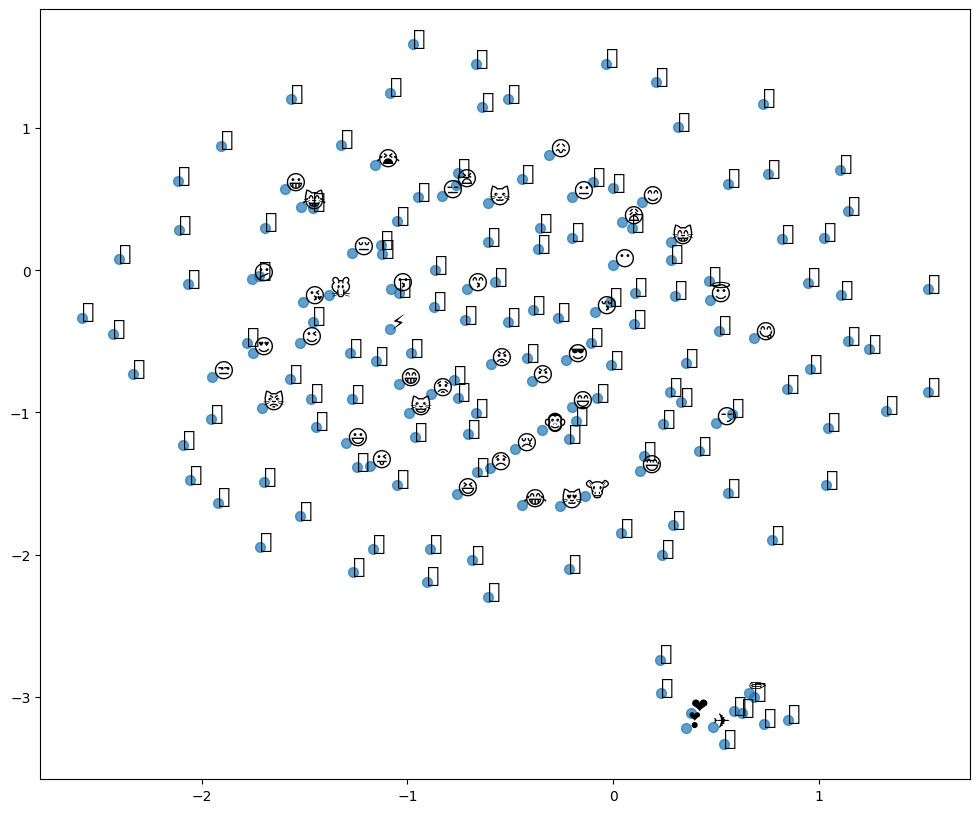

In [7]:
X = np.stack(list(emoji_embeddings.values()))
labels = list(emoji_embeddings.keys())

X_embedded = UMAP(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=50, alpha=0.7)

for i, label in enumerate(labels):
    plt.text(
        X_embedded[i,0], 
        X_embedded[i,1], 
        label, 
        fontsize=15
    )
plt.show()